In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp

from glob import glob
from collections import OrderedDict

from pylab import plt
from scipy.signal import detrend, butter, filtfilt, welch

import mne

%matplotlib inline

from IPython.display import HTML

sns.set(sns.plotting_context("paper", font_scale=1.2), 
        style="whitegrid")



# File list

In [2]:
files_list = glob('../data/*/*/*/*')
files_list

['../data/g.tec/g.USBamp/S0001/gtec-blinks.csv',
 '../data/g.tec/g.USBamp/S0001/gtec-closed.csv',
 '../data/g.tec/g.USBamp/S0001/gtec-input_noise.csv',
 '../data/g.tec/g.USBamp/S0001/gtec-open.csv',
 '../data/neuroConn/NeuroPrax/S0001/neuroconn-blinks.EDF',
 '../data/neuroConn/NeuroPrax/S0001/neuroconn-closed.EDF',
 '../data/neuroConn/NeuroPrax/S0001/neuroconn-input_noise.EDF',
 '../data/neuroConn/NeuroPrax/S0001/neuroconn-open.EDF',
 '../data/wearable-sensing/DSI-24/S0001/DSI-blinks.csv',
 '../data/wearable-sensing/DSI-24/S0001/DSI-closed.csv',
 '../data/wearable-sensing/DSI-24/S0001/DSI-open.csv']

# Blinks

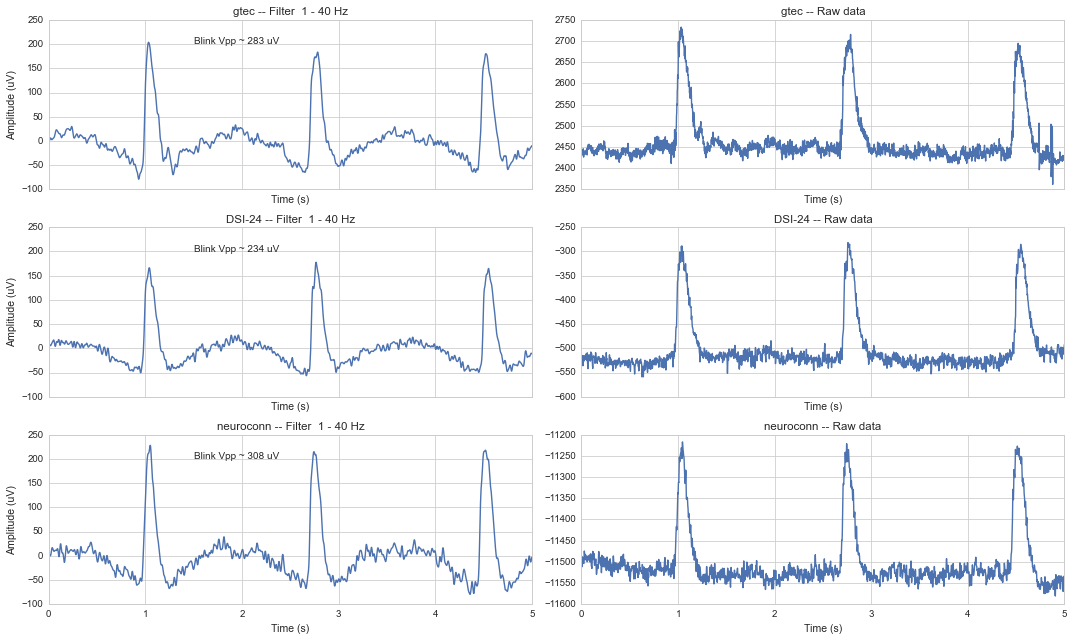

In [3]:
signals = OrderedDict()
freqs = OrderedDict()

signals['gtec'] = pd.read_csv('../data/g.tec/g.USBamp/S0001/gtec-blinks.csv',
                              index_col=0,delimiter=';').values[:,0]
freqs['gtec'] = 512.0

signals['DSI-24'] = pd.read_csv('../data/wearable-sensing/DSI-24/S0001/DSI-blinks.csv',
                                index_col=0,delimiter=';').values[:,0]
freqs['DSI-24'] = 300.0

data = mne.io.read_raw_edf('../data/neuroConn/NeuroPrax/S0001/neuroconn-blinks.EDF',
                           preload=True, stim_channel=None, verbose=False)._data
# neuroconn save file without referencing signal. do it ny hand
signals['neuroconn']= 1e6*(data[0,:] - data[-1,:]).T
freqs['neuroconn'] = 512.0

Ng = len(signals)
fig, axes = plt.subplots(Ng,2, figsize=[15, 3*Ng], sharex=True, sharey=False)


for i, device in enumerate(signals):
    data = signals[device]
    freq = freqs[device]

    sl = slice(int(5*freq),int(15*freq))

    b, a = butter(5, np.array([1., 40])/(freq/2), 'bandpass')
    dataf = filtfilt(b,a, data)
    

    ix = np.where(dataf[sl]>100)[0][0]
    start = sl.start + ix - np.int(freq)
    sl = slice(start, start + int(5*freq))
    t = np.arange(0,len(data[sl])/freq, 1/freq)

    vppf = np.max(dataf[sl]) - np.min(dataf[sl])
    axes[i,0].text(1.5, 200, 'Blink Vpp ~ %.0f uV' % vppf)
    axes[i,0].set_ylabel('Amplitude (uV)')
    axes[i,0].plot(t, dataf[sl])
    axes[i,0].set_ylim(-100, 250)
    axes[i,0].set_xlim(t[0], t[-1])
    axes[i,0].set_title('%s -- Filter  1 - 40 Hz' % device)
    axes[i,0].set_xlabel('Time (s)')

    axes[i,1].set_xlabel('Time (s)')
    axes[i,1].plot(t, data[sl])
    axes[i,1].set_title('%s -- Raw data' % device);
    axes[i,1].set_xlim(t[0], t[-1])


plt.tight_layout()
plt.savefig('blinks.png', dpi=150)

# Alpha

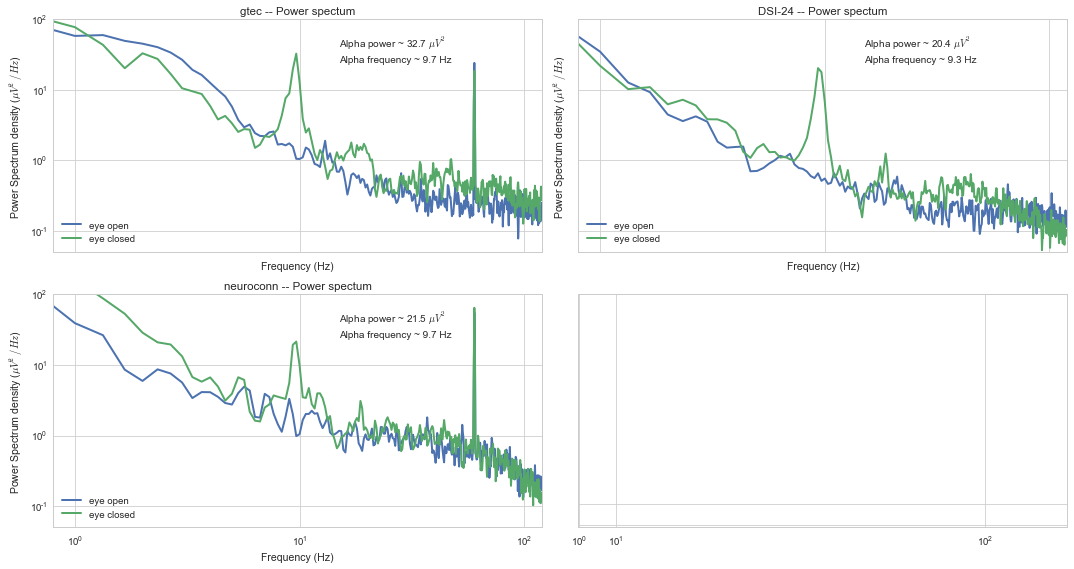

In [4]:
#data = mne.io.read_raw_edf('./neuroconn-blinks.EDF', preload=True, stim_channel=None)._data
#data = 1e6*(data[1,:] - data[-1,:]).T
from collections import OrderedDict
from scipy.signal import argrelextrema

signals = OrderedDict()
signals_c = OrderedDict()
freqs = OrderedDict()


signals['gtec'] = pd.read_csv('../data/g.tec/g.USBamp/S0001/gtec-open.csv',
                              index_col=0,delimiter=';').values[:,0]
freqs['gtec'] = 512.0

signals['DSI-24'] = pd.read_csv('../data/wearable-sensing/DSI-24/S0001/DSI-open.csv',
                                index_col=0,delimiter=';').values[:,0]
freqs['DSI-24'] = 300.0

data = mne.io.read_raw_edf('../data/neuroConn/NeuroPrax/S0001/neuroconn-open.EDF',
                           preload=True, stim_channel=None, verbose=False)._data
signals['neuroconn']= 1e6*(data[0,:] - data[-1,:]).T
freqs['neuroconn'] = 512.0

signals_c['gtec'] = pd.read_csv('../data/g.tec/g.USBamp/S0001/gtec-closed.csv',
                                index_col=0,delimiter=';').values[:,0]

signals_c['DSI-24'] = pd.read_csv('../data/wearable-sensing/DSI-24/S0001/DSI-closed.csv',
                                  index_col=0,delimiter=';').values[:,0]

data = mne.io.read_raw_edf('../data/neuroConn/NeuroPrax/S0001/neuroconn-closed.EDF',
                           preload=True, stim_channel=None, verbose=False)._data
signals_c['neuroconn']= 1e6*(data[0,:] - data[-1,:]).T

Ng = (len(signals) % 2) + 1
fig, axes = plt.subplots(Ng, 2, figsize=[15, 4*Ng], sharex=True, sharey=True)
axes = axes.flatten()


for i, device in enumerate(signals):
    data = signals[device]
    data_c = signals_c[device]
    freq = freqs[device]
    window = np.int(3*freq)
    noverlap = np.int(0.95*window)

    sl = slice(int(5*freq),int(30*freq))

    f, p_o = welch(data[sl], fs=freq, nperseg=window, noverlap=noverlap, scaling='density')
    ix = (f<120)

    axes[i].semilogy(f[ix],p_o[ix], lw=2);

    
    f, p = welch(data_c[sl], fs=freq, nperseg=window, noverlap=noverlap, scaling='density')
    ix = (f<120)

    axes[i].semilogy(f[ix],p[ix], lw=2);
    axes[i].semilogx()
    axes[i].set_ylim(0.05, 100)
    axes[i].set_xlim(0.8, 120)

    ix = (f>8) & (f<12)
    
    ix_alpha = np.argmax(p[ix])
    alpha_p = p[ix][ix_alpha]
    axes[i].text(15, 40, 'Alpha power ~ %.1f $\mu V^2$' % alpha_p)
    axes[i].text(15, 25, 'Alpha frequency ~ %.1f Hz' % f[ix][ix_alpha])

    
    axes[i].legend(['eye open', 'eye closed'], loc='lower left')

    axes[i].set_xlabel('Frequency (Hz)');
    axes[i].set_ylabel('Power Spectrum density ($\mu V^2 / Hz$)');
    axes[i].set_title('%s -- Power spectum' % device);

    
plt.tight_layout()
plt.savefig('alpha-log.png', dpi=150)

# Input noise

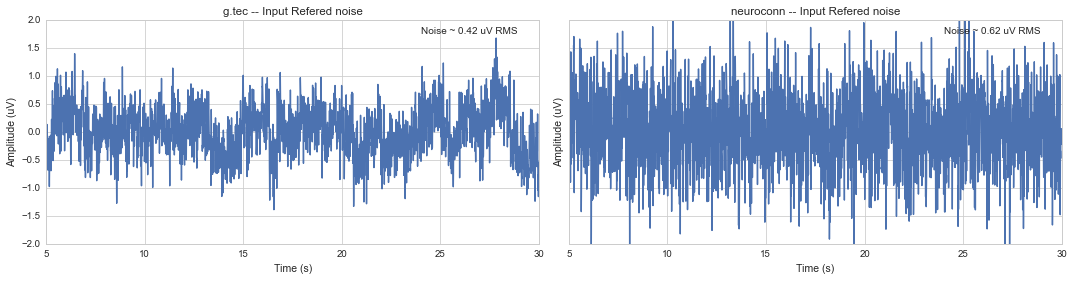

In [5]:
noise = OrderedDict()
signals = OrderedDict()
freqs = OrderedDict()

bandpass = [0.1, 40]

signals['g.tec'] = pd.read_csv('../data/g.tec/g.USBamp/S0001/gtec-input_noise.csv',
                               index_col=0, delimiter=';').values[:,0]
freqs['g.tec'] = 512.0

data = mne.io.read_raw_edf('../data/neuroConn/NeuroPrax/S0001/neuroconn-input_noise.EDF',
                           preload=True, stim_channel=None, verbose=False)._data
signals['neuroconn'] = 1e6*(data[0,:]).T
freqs['neuroconn'] = 512.0

Ng = (len(signals) % 2) + 1
fig, axes = plt.subplots(Ng, 2, figsize=[15, 4*Ng], sharex=True, sharey=True)

axes = axes.flatten()
for i, device in enumerate(signals):
    data = signals[device]
    freq = freqs[device]

    b, a = butter(3, np.array(bandpass)/(freq/2), 'bandpass')
    dataf = detrend(filtfilt(b,a, data))
    t = np.arange(0,len(dataf)/freq, 1/freq)


    sl = slice(int(5*freq),int(30*freq))
    axes[i].plot(t[sl], dataf[sl])
    axes[i].set_ylim(-2,2)
    axes[i].set_xlim(t[sl.start],t[sl.stop])
    axes[i].set_ylabel('Amplitude (uV)')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_title('%s -- Input Refered noise' % device)

    noise[device] = np.std(dataf[sl])
    noise[device]
    axes[i].text(24, 1.75, 'Noise ~ %.2f uV RMS' % noise[device])

plt.tight_layout()
plt.savefig('input-noise.png', dpi=150)